### Importación de librerias

In [1]:

import warnings
warnings.filterwarnings('ignore')

import pylab as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

from keras import Sequential 
from keras.layers import Dense 

from keras.callbacks import Callback, EarlyStopping 

from tensorflow.keras.optimizers.legacy import RMSprop 

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

### Carga de datos

In [2]:
df = pd.read_csv(r"C:\Users\apico\OneDrive\Escritorio\DEEP LEARNING\PRACTICAS\BBDD\realtor-data.csv")
df.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [3]:
df.shape

(512159, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512159 entries, 0 to 512158
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        512159 non-null  object 
 1   price         512159 non-null  float64
 2   bed           413222 non-null  float64
 3   bath          416941 non-null  float64
 4   acre_lot      407180 non-null  float64
 5   full_address  512159 non-null  object 
 6   street        511543 non-null  object 
 7   city          512100 non-null  object 
 8   state         512159 non-null  object 
 9   zip_code      511962 non-null  float64
 10  house_size    395693 non-null  float64
 11  sold_date     202507 non-null  object 
dtypes: float64(6), object(6)
memory usage: 46.9+ MB


### Limpieza y transformación de datos

In [6]:
# Eliminamos columnas no representativas

df = df.drop(['status', 'full_address', 'street', 'sold_date', 'city','zip_code'], axis =1)

In [7]:
# Buscamos valores nulos
df.isna().sum()

price              0
bed            98937
bath           95218
acre_lot      104979
state              0
house_size    116466
dtype: int64

In [8]:
# Buscamos negativos
columnas = ['price','bed','bath','acre_lot','house_size']
negativos = (df[columnas] < 0).any()
negativos

price         False
bed           False
bath          False
acre_lot      False
house_size    False
dtype: bool

In [9]:
# Buscamos valores 0 en todas las columnas
columnas = ['price','bed','bath','acre_lot','house_size']
valores_0 = (df[columnas] == 0).any()
valores_0

price          True
bed           False
bath          False
acre_lot       True
house_size    False
dtype: bool

In [10]:
# Eliminamos registros con valor 0 en el precio y los acres.
# No se puede vender una vivienda con precio o parcela importe 0.

df = df[df['price'] != 0]
df = df[df['acre_lot'] != 0]
df.shape

(511868, 6)

In [11]:
# Buscamos NaN en camas, baños, tamaño de casa y acres positivos 
# En el caso de existir registros, nos dará a entender que son extensiones de tierra sin casa.

df_nan = df.loc[df.bed.isna() & df.bath.isna() & df.house_size.isna() & df.acre_lot > 0]
df_nan.head()

,price,bed,bath,acre_lot,state,house_size
43,380000.0,NaN,NaN,18.45,Puerto Rico,NaN
59,35000.0,NaN,NaN,0.88,Puerto Rico,NaN
60,58000.0,NaN,NaN,0.21,Puerto Rico,NaN
61,85000.0,NaN,NaN,21.08,Puerto Rico,NaN
62,47000.0,NaN,NaN,0.57,Puerto Rico,NaN


In [12]:
# Eliminamos registros con NaN comunes en camas, baños, acres y tamaño de casa.
df = df.drop(df_nan.index)

In [13]:
# Buscamos registros con NaN comunes en camas, baños, acres y tamaño de casa.

df_nan2 = df.loc[df.bed.isna() & df.bath.isna() & df.house_size.isna() & df.acre_lot.isna()]
df_nan2.head()

,price,bed,bath,acre_lot,state,house_size
818,497000.0,NaN,NaN,NaN,Puerto Rico,NaN
849,497000.0,NaN,NaN,NaN,Puerto Rico,NaN
2632,497000.0,NaN,NaN,NaN,Puerto Rico,NaN
3130,497000.0,NaN,NaN,NaN,Puerto Rico,NaN
3664,497000.0,NaN,NaN,NaN,Puerto Rico,NaN


In [14]:
# Eliminamos registros con NaN comunes en camas, baños, acres y tamaño de casa.

df = df.drop(df_nan2.index)

In [15]:
df_nan3 = df.loc[df.bed.isna() & df.bath.isna()& df.acre_lot.isna()]
df_nan3.head()

,price,bed,bath,acre_lot,state,house_size
103087,350000.0,NaN,NaN,NaN,Massachusetts,999.0
104725,350000.0,NaN,NaN,NaN,Massachusetts,999.0
108915,350000.0,NaN,NaN,NaN,Massachusetts,999.0
109544,169000.0,NaN,NaN,NaN,Massachusetts,200.0
121575,350000.0,NaN,NaN,NaN,Massachusetts,999.0


In [16]:
# Eliminamos registros con NaN comunes en camas, baños, acres.

df = df.drop(df_nan3.index)

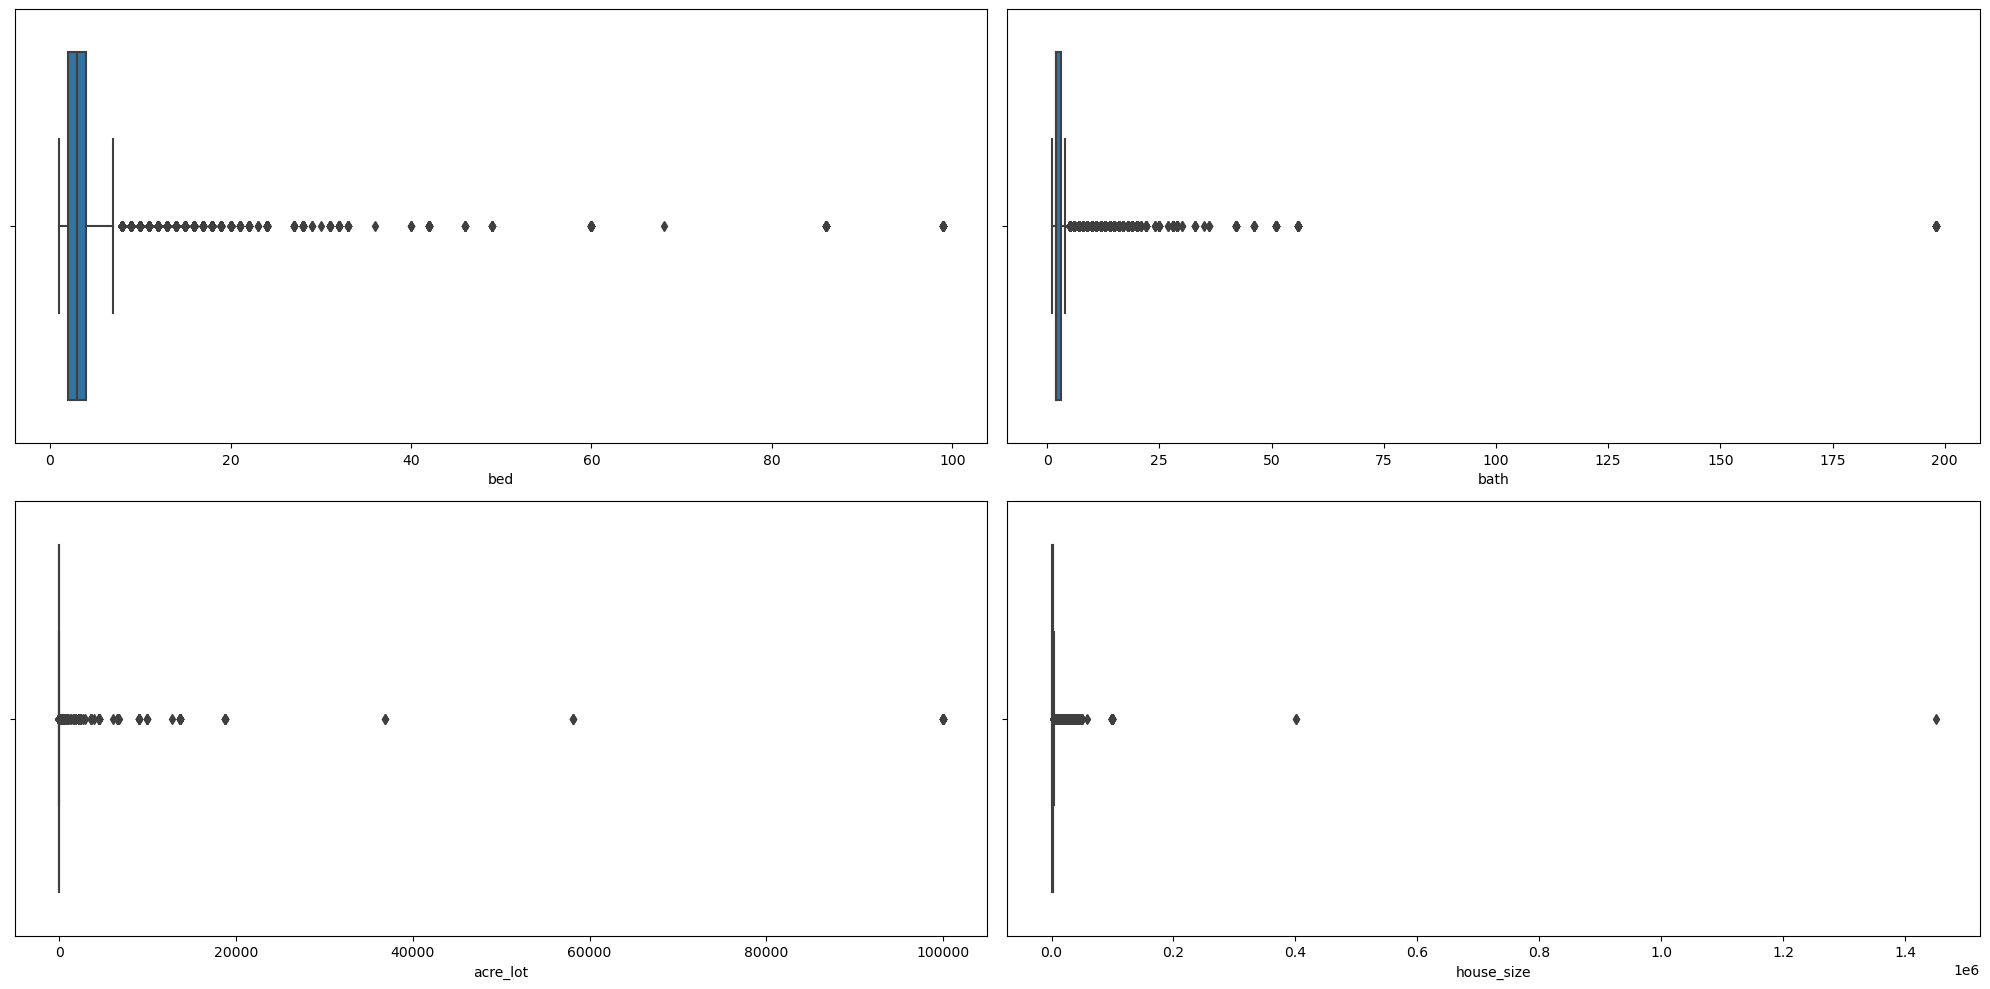

In [17]:
# Visualización de datos en busca de outliers o erroneos

num_vars = ['bed', 'bath', 'acre_lot', 'house_size']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df, ax=axs[i])

fig.tight_layout()

plt.show()

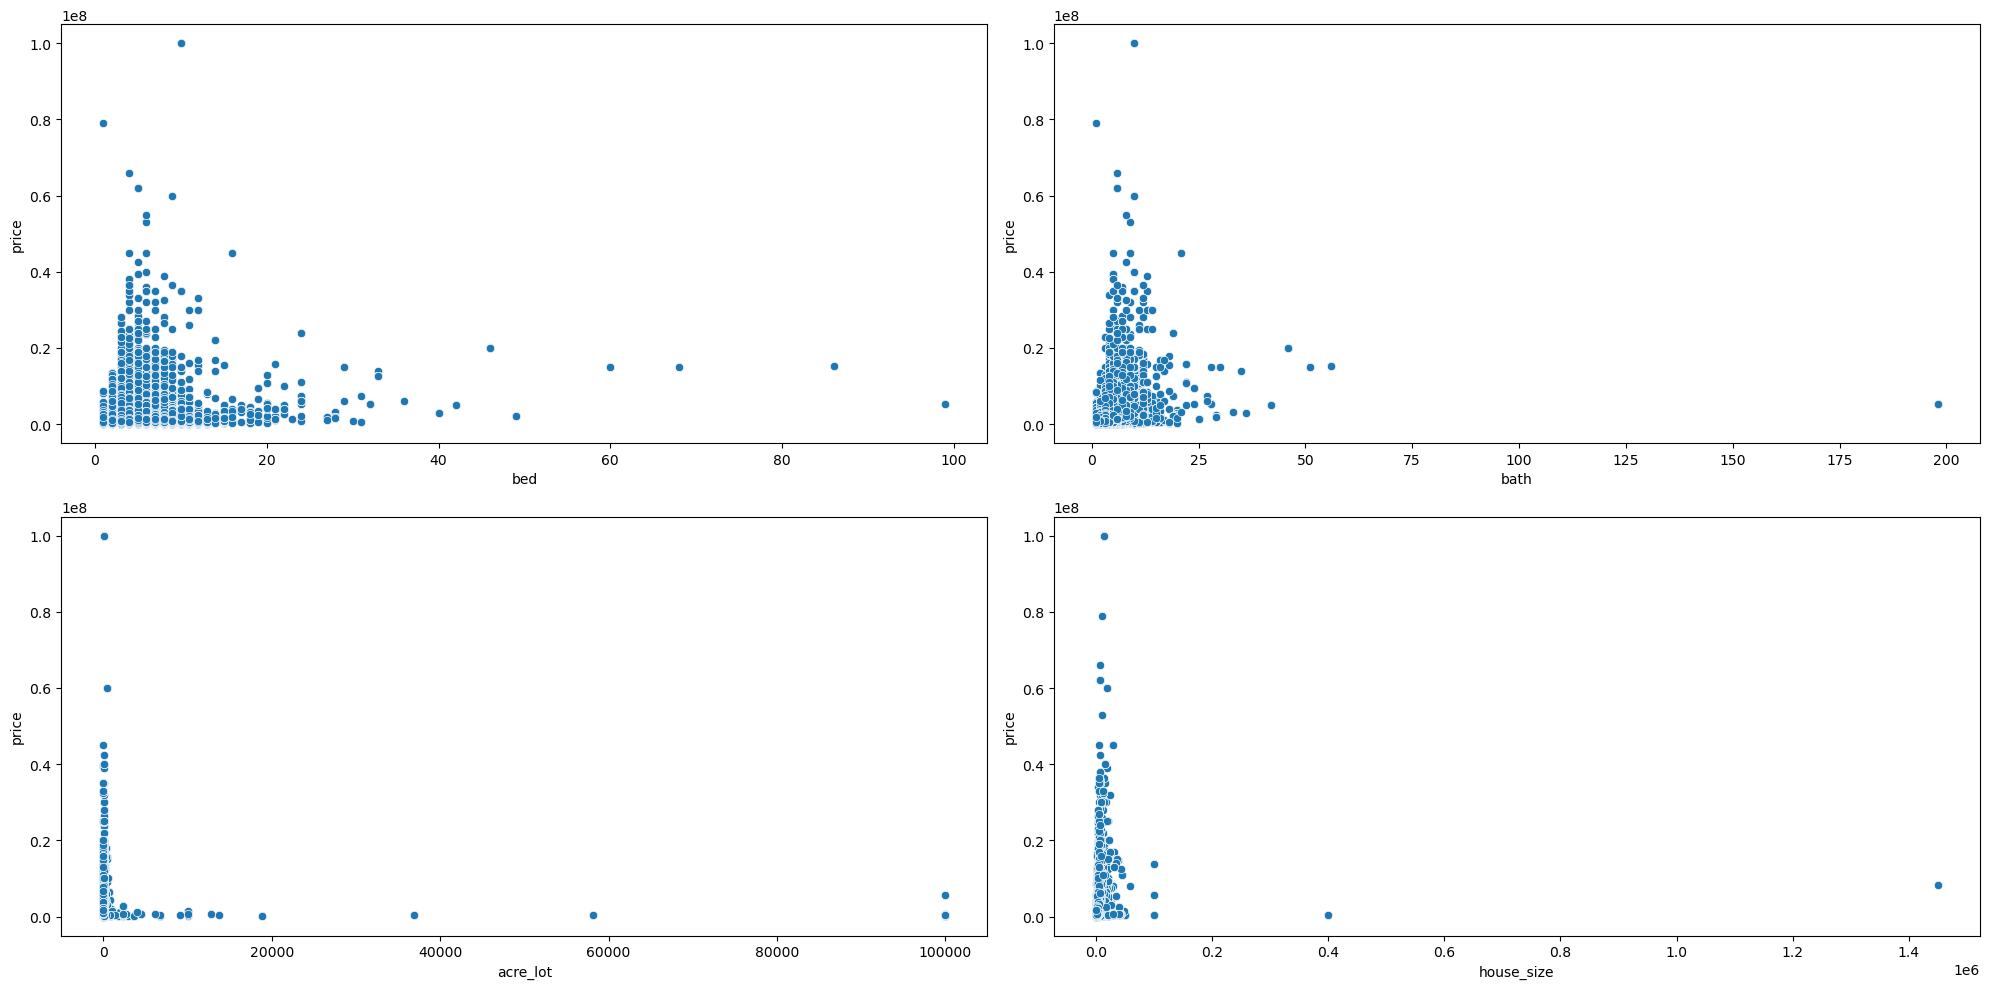

In [18]:
# Visualización de datos en busca de outliers o erroneos

num_vars = ['bed', 'bath', 'acre_lot', 'house_size']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.scatterplot(x=var, y='price', data=df, ax=axs[i])

fig.tight_layout()

plt.show()

In [19]:
df = df.dropna()

In [20]:
df.shape

(294250, 6)

In [21]:
df.isna().sum()

price         0
bed           0
bath          0
acre_lot      0
state         0
house_size    0
dtype: int64

In [22]:
df.head()

,price,bed,bath,acre_lot,state,house_size
0,105000.0,3.0,2.0,0.12,Puerto Rico,920.0
1,80000.0,4.0,2.0,0.08,Puerto Rico,1527.0
2,67000.0,2.0,1.0,0.15,Puerto Rico,748.0
3,145000.0,4.0,2.0,0.10,Puerto Rico,1800.0
5,179000.0,4.0,3.0,0.46,Puerto Rico,2520.0


In [23]:
# Buscamos valores atípicos para determinar que técnica utilizamos para la normalización de datos

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Establecer un umbral para los valores atípicos
umbral = 2

# Eliminar los valores atípicos del dataframe
df = df[~((df < Q1 - umbral * IQR) | (df > Q3 + umbral * IQR)).any(axis=1)]

df.shape

(226015, 6)

Text(0.5, 1.0, 'Comparativa de precios por estado')

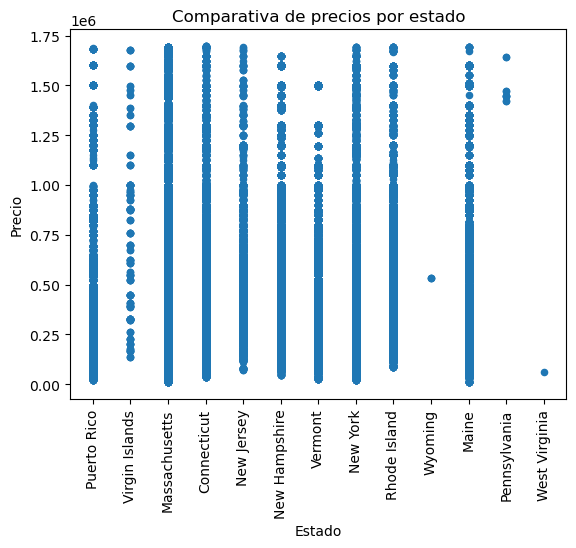

In [24]:
# Crear el gráfico de puntos
df.plot(kind='scatter', x='state', y='price')

# Personalizar el gráfico
plt.xticks(rotation=90)
plt.xlabel('Estado')
plt.ylabel('Precio')
plt.title('Comparativa de precios por estado')

In [25]:
df['state'].unique()

array(['Puerto Rico', 'Virgin Islands', 'Massachusetts', 'Connecticut',
       'New Jersey', 'New Hampshire', 'Vermont', 'New York',
       'Rhode Island', 'Wyoming', 'Maine', 'Pennsylvania',
       'West Virginia'], dtype=object)

In [26]:
# Aplicamos get dummies para que todas las columnas valgan lo mismo 

df = pd.get_dummies(df, columns=['state'])

# Modificacmos nombres de las columnas

df.rename(columns = {'state_1': 'Puerto Rico', 'state_2': 'Virgin Islands','state_3': 'Massachusetts',
                    'state_4': 'Connecticut', 'state_5': 'New Jersey','state_6': 'New York',
                     'state_7': 'New Hampshire', 'state_8': 'Vermont','state_9': 'Rhode Island',
                    'state_10': 'Wyoming', 'state_11': 'Maine','state_12': 'Georgia',
                    'state_13': 'Pennsylvania', 'state_14': 'West Virginia'
                    }, inplace=True)
df.columns = df.columns.str.replace('state_', '')

In [27]:
df.head()

,price,bed,bath,acre_lot,house_size,Connecticut,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Puerto Rico,Rhode Island,Vermont,Virgin Islands,West Virginia,Wyoming
0,105000.0,3.0,2.0,0.12,920.0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,80000.0,4.0,2.0,0.08,1527.0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,67000.0,2.0,1.0,0.15,748.0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,145000.0,4.0,2.0,0.10,1800.0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,179000.0,4.0,3.0,0.46,2520.0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Separación e inspección de los datos 

In [28]:
X = df.drop('price', axis=1)

y = df.price

In [29]:
# Normalización

X[X.columns] = StandardScaler().fit_transform(X)
X.head()

,bed,bath,acre_lot,house_size,Connecticut,Maine,Massachusetts,New Hampshire,New Jersey,New York,Pennsylvania,Puerto Rico,Rhode Island,Vermont,Virgin Islands,West Virginia,Wyoming
0,-0.353048,-0.266256,-0.717170,-1.122350,-0.57383,-0.27674,-0.728148,-0.294332,-0.130173,-0.167066,-0.006652,4.036088,-0.321986,-0.24943,-0.026699,-0.002103,-0.003643
1,0.584030,-0.266256,-0.784704,-0.428617,-0.57383,-0.27674,-0.728148,-0.294332,-0.130173,-0.167066,-0.006652,4.036088,-0.321986,-0.24943,-0.026699,-0.002103,-0.003643
2,-1.290125,-1.338523,-0.666520,-1.318927,-0.57383,-0.27674,-0.728148,-0.294332,-0.130173,-0.167066,-0.006652,4.036088,-0.321986,-0.24943,-0.026699,-0.002103,-0.003643
3,0.584030,-0.266256,-0.750937,-0.116609,-0.57383,-0.27674,-0.728148,-0.294332,-0.130173,-0.167066,-0.006652,4.036088,-0.321986,-0.24943,-0.026699,-0.002103,-0.003643
5,0.584030,0.806012,-0.143134,0.706270,-0.57383,-0.27674,-0.728148,-0.294332,-0.130173,-0.167066,-0.006652,4.036088,-0.321986,-0.24943,-0.026699,-0.002103,-0.003643


In [30]:
# Separacion en paquetes de entrenamiento y testeo

X_train, X_test, y_train, y_test = tts(X, y)

In [31]:
# Contamos elementos que componen las datos de prueba y validación

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((169511, 17), (56504, 17), (169511,), (56504,))

### Modelo

Vamos a utilizar un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. 

In [32]:
# Iniciamos una red vacia(sin capas)

model = Sequential() 

# 1a capa 

model.add(Dense(64,                  
                activation='relu',  
                input_shape=[X_train.shape[1]])) 

# 2da capa --> sin X_train.shape
model.add(Dense(64, activation='relu'))


model.add(Dense(1))



optimizer = RMSprop(0.001)

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) 

In [33]:
# Inspeccion del modelo

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


**Entrenamiento**

In [34]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
5298/5298 [==============================] - 4s 720us/step - loss: 150096936960.0000 - mae: 287215.8750 - mse: 150096936960.0000
Epoch 2/10
5298/5298 [==============================] - 4s 718us/step - loss: 53653282816.0000 - mae: 158763.9688 - mse: 53653282816.0000
Epoch 3/10
5298/5298 [==============================] - 4s 715us/step - loss: 52238458880.0000 - mae: 157390.1562 - mse: 52238458880.0000
Epoch 4/10
5298/5298 [==============================] - 4s 719us/step - loss: 51957530624.0000 - mae: 156883.3281 - mse: 51957530624.0000
Epoch 5/10
5298/5298 [==============================] - 4s 714us/step - loss: 51754504192.0000 - mae: 156322.0000 - mse: 51754504192.0000
Epoch 6/10
5298/5298 [==============================] - 4s 738us/step - loss: 51594928128.0000 - mae: 155948.7188 - mse: 51594928128.0000
Epoch 7/10
5298/5298 [==============================] - 4s 710us/step - loss: 51474432000.0000 - mae: 155674.7188 - mse: 51474432000.0000
Epoch 8/10
5298/5298 [==========

In [35]:
class PrintDot(Callback):
    
  def on_epoch_end(self, epoch, logs):
    # pintame un punto cada 100 epocas
    if epoch % 100 == 0: 
        print('')
    else:
        print('.', end='')

In [36]:
EPOCAS = 50

In [37]:
history = model.fit(X_train, y_train,
                    epochs=EPOCAS, 
                    validation_split = 0.2, # ajuste interno de la propia red
                    verbose=0,
                    callbacks=[PrintDot()])


.................................................

In [38]:
history

### Resultados

In [39]:
pd.DataFrame(history.history).head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,5.097051e+10,154812.046875,5.097051e+10,5.183837e+10,156195.281250,5.183837e+10
1,5.092481e+10,154703.062500,5.092481e+10,5.172093e+10,155376.218750,5.172093e+10
2,5.086893e+10,154639.578125,5.086893e+10,5.167915e+10,155327.265625,5.167915e+10
3,5.082813e+10,154529.875000,5.082813e+10,5.163865e+10,154777.078125,5.163865e+10
4,5.077964e+10,154411.171875,5.077964e+10,5.159697e+10,154989.468750,5.159697e+10


In [40]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [price]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.legend()
    
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$price^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    
    plt.show();

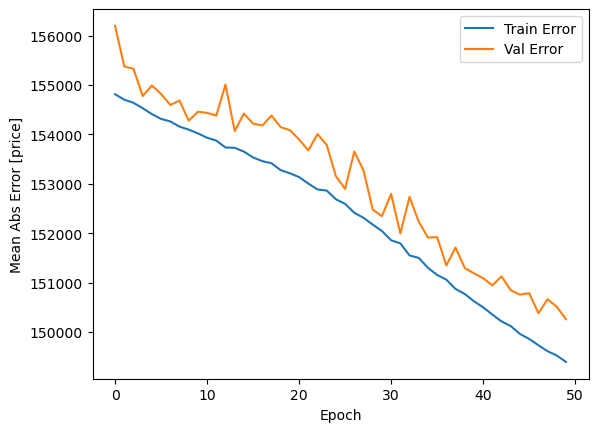

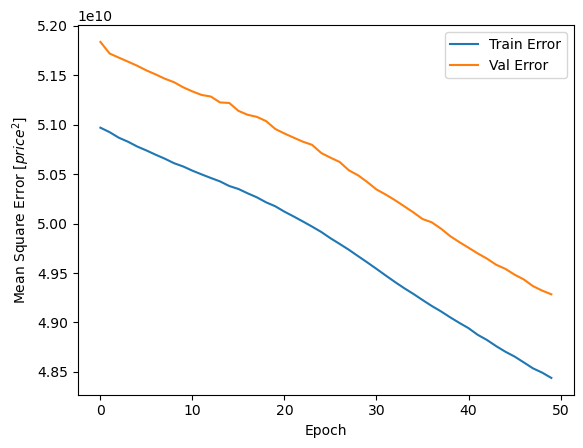

In [41]:
plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 50 épocas. 

Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

In [42]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=[X_train.shape[1]]))

model.add(Dense(64, activation='relu'))

model.add(Dense(1))


optimizer = RMSprop(0.001)


model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])  

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [44]:
history = model.fit(X_train, y_train,
                    epochs=EPOCAS, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])


.................................................

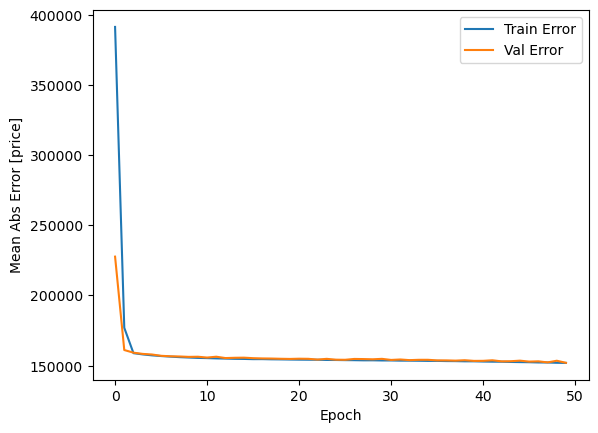

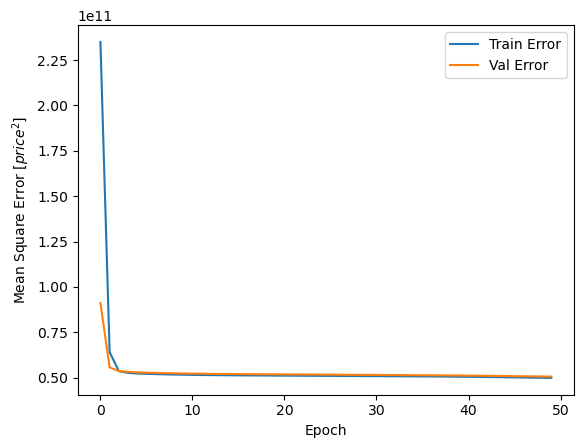

In [45]:
plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 0.1 precio. ¿Es esto bueno? 

Veamos qué tan bien generaliza el modelo al usar el conjunto de testeo, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

### Predicciones

In [46]:
y_pred = model.predict(X_test).flatten()

1766/1766 [==============================] - 1s 529us/step


In [47]:
y_pred[:10]

array([321110.6 , 530607.3 , 275084.28, 416830.66, 326222.53, 515508.66,
       369664.6 , 758086.2 , 538538.4 , 760101.44], dtype=float32)

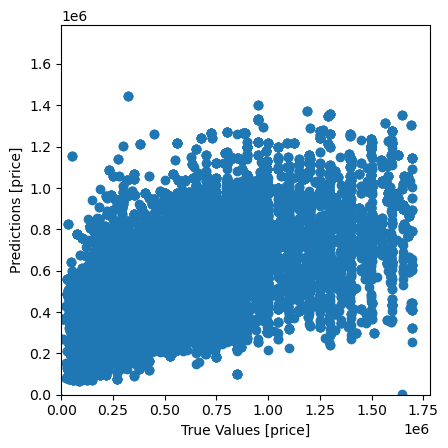

In [48]:
plt.scatter(y_test, y_pred)

plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')

plt.axis('equal')
plt.axis('square')

plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

_ = plt.plot([-100, 100], [-100, 100])

In [49]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=1)

print('Testing MAE: {:5.2f} price'.format(mae))
print('Testing RMSE: {:5.2f} price'.format(mse**0.5))

1766/1766 [==============================] - 1s 636us/step - loss: 50319548416.0000 - mae: 151951.9844 - mse: 50319548416.0000
Testing MAE: 151951.98 price
Testing RMSE: 224320.19 price


In [50]:
y.mean(), y.std()

(472395.5649890494, 310511.16486485244)

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

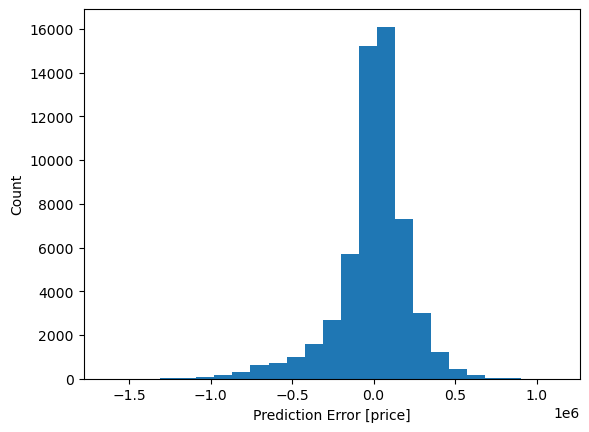

In [51]:
error = y_pred - y_test

plt.hist(error, bins = 25)

plt.xlabel('Prediction Error [price]')
_ = plt.ylabel('Count')

Conclusión

Esta tabla ha llegado con muchos nulos que he tenido que filtrar para poder limpiarla. En primer lugar, he eliminado todas las columnas que no eran representativas para el modelo. Despues, he eliminado todos los valores nulos, 0 y negativos que habian en todas las columnas, ya que al rellenar todos los nulos con media y medianas, el resultado ha sido peor.
Al visualizar los datos se ve claramente la existencia de outliers que he eliminado para poder pasar ha realizar la categorización y despues la normalización.
Con lo que respecta al modelo, le he asignado 64 neuronas, 2 capas y 10 épocas pero no ha sido suficiente, el MAE me ha salido 151951 y el MSE 224320, lo cual nos está diciendo que tendriamos un rendimiento deficiente en términos de precisión de predicción de precios, ya que los errores promedio son bastante altos.